In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt 
from IPython.display import Image as displayImage
from matplotlib.animation import FuncAnimation
import pydicom as dicom
import pydicom as dc
from PIL import Image
import pydicom
from pathlib import Path
import copy
import os
import scipy.ndimage

import glob
import numpy as np
"""Use sliders to slice volume
Click button to change colormap"""

'Use sliders to slice volume\nClick button to change colormap'

In [2]:
Root_path_images = "D:\\Jupyter Notebooks\\Freelancing\\Monai Dicom\\Dicom Processing\\Extracted Dicom Slices Artries\\Carotid007\\IMAGES\\IM00191"
file_input = "D:\\Jupyter Notebooks\\Freelancing\\Monai Dicom\\Dicom Processing\\Extracted Dicom Slices Artries\\Carotid007\\IMAGES\\"

In [3]:
read_file = dc.read_file(Root_path_images)
img_file = read_file.pixel_array
print(f"\nand shape of images are {img_file.shape}")


and shape of images are (512, 512)


In [4]:
#      
# Loop over the image files and store everything into a list.
# 

def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    ps = slices[0].PixelSpacing
    ss = slices[0].SliceThickness
    ax_aspect = ps[1] / ps[0]
    sag_aspect = ps[1] / ss
    cor_aspect = ss / ps[0]
    return slices , ax_aspect , sag_aspect , cor_aspect

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=0
patient , ax_aspect , sag_aspect , cor_aspect = load_scan(file_input)
imgs = get_pixels_hu(patient)

In [87]:
print("Slice Thickness: %f" % patient[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Slice Thickness: 0.625000
Pixel Spacing (row, col): (0.443359, 0.443359) 


In [10]:
desired_spacing = [1, 1, 1]
X = 0
Y = 1
Z = 2
def resample3d(image, scan, new_spacing):
    # Determine current pixel spacing
    spacing = map(float, [scan[0].PixelSpacing[X], scan[0].PixelSpacing[Y], scan[0].SliceThickness])
    spacing = np.array(list(spacing))
    
    resize_x    = spacing[X] / new_spacing[X]
    new_shape_x = np.round(image.shape[X] * resize_x)
    resize_x    = float(new_shape_x) / float(image.shape[X])
    sx = spacing[X] / resize_x

    resize_y    = spacing[Y] / new_spacing[Y]
    new_shape_y = np.round(image.shape[Y] * resize_y)
    resize_y    = new_shape_y / image.shape[Y]
    sy = spacing[Y] / resize_y

    resize_z    = spacing[Z] / new_spacing[Z]
    new_shape_z = np.round(image.shape[Z] * resize_z)
    resize_z    = float(new_shape_z) / float(image.shape[Z])
    sz = spacing[Z] / resize_z
    
    image = scipy.ndimage.interpolation.zoom(image, (resize_x, resize_y, resize_z), order=1)
    
    return (image, (sx, sy, sz))

print(f"Shape befoimgs_after_resampre resampling\t{imgs.shape}")
imgs_after_resamp, spacing = resample3d(imgs, patient, desired_spacing)
print(f"Shape after resampling:\t{imgs_after_resamp.shape}")
print(f"New spacing: {spacing}")

Shape befoimgs_after_resampre resampling	(360, 512, 512)


C:\Users\husse\AppData\Local\Temp\ipykernel_660\4063565505.py:25: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  image = scipy.ndimage.interpolation.zoom(image, (resize_x, resize_y, resize_z), order=1)


Shape after resampling:	(160, 227, 320)
New spacing: (0.99755775, 0.999999154185022, 1.0)


In [9]:
# The shape of the stacked images in each plane
# (Axial, Coronal, and Sagittal, respectively)
n0, n1, n2 = imgs_after_resamp.shape
# Print the ouput
print("Number of Slices:\n\t", "Axial=", n0, "Slices\n\t",
                               "Coronal=", n1, "Slices\n\t",
                               "Sagittal=", n2, "Slices")

Number of Slices:
	 Axial= 160 Slices
	 Coronal= 227 Slices
	 Sagittal= 320 Slices


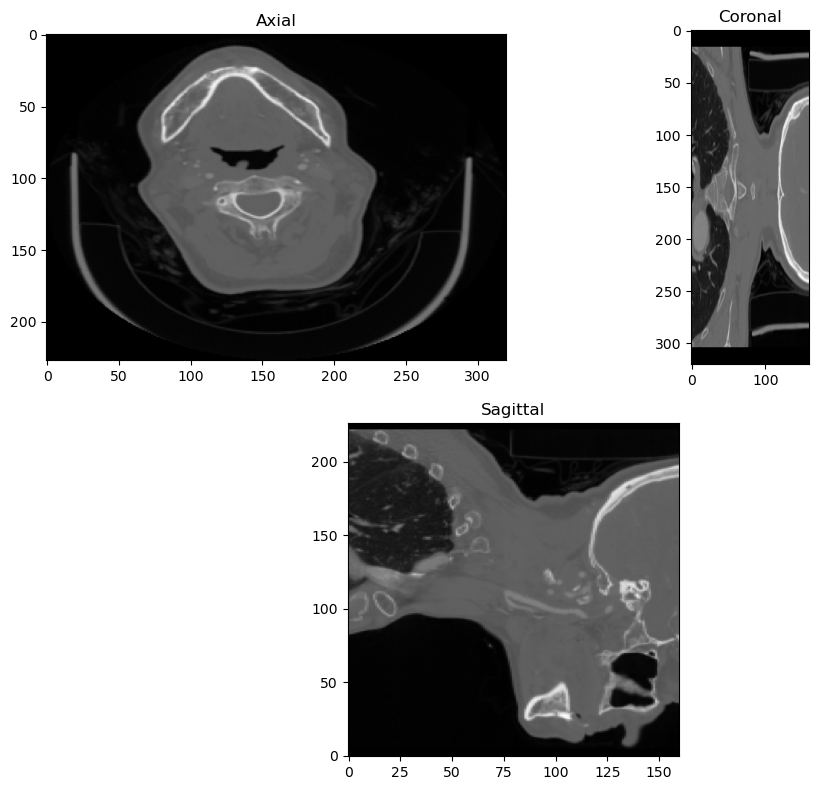

In [11]:
# Create a larger subplot figure
plt.figure(figsize=(10, 8))

# Plot the orthogonal slices
a1 = plt.subplot(2, 2, 1)
plt.imshow(imgs_after_resamp[100,:,: ], cmap="gray")
a1.set_aspect(ax_aspect)
a1.set_title('Axial')

a2 = plt.subplot(2, 2, 2)
plt.imshow(imgs_after_resamp[:, 162, :].T, cmap="gray")
a2.set_aspect(cor_aspect)
a2.set_title('Coronal')
a3 = plt.subplot(2, 1, 2)  # Using 2 rows, 1 column for larger coronal plot
plt.imshow(imgs_after_resamp[:, :,112 ].T, cmap="gray", origin='lower')
a3.set_aspect(sag_aspect)
a3.set_title('Sagittal')

plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()

In [13]:
# Add three sliders that start with 0 and ends at the number of slices
# along each plane.
# Axial:    n0=99   slice
# Corornal: n1=512  slice
# Sagittal: n2=512  slice
@widgets.interact(axial_slice=(0,n0-1), coronal_slice=(0,n1-1),\
                  sagittal_slice=(0,n2-1))
def slicer(axial_slice, coronal_slice=100, sagittal_slice=100):
  fig, ax = plt.subplots(1, 3, figsize=(16, 16))


  # Show the specfied slice on the axial plane with 'gray' color-map
  # and axial aspect ratio.
  ax[0].imshow(imgs_after_resamp[axial_slice,:,:], cmap='gray', aspect= ax_aspect)
  ax[0].axis('off')
  ax[0].set_title('Axial')

  # Show the specified slice on the coronal plane with 'gray' color-map
  # and coronal aspect ratio.
  ax[1].imshow(imgs_after_resamp[:,coronal_slice,:],cmap='gray', aspect= cor_aspect)
  ax[1].axis('off')
  ax[1].set_title('Coronal')

  # Show the specified slice on the sagittal plane with 'gray' color-map
  # and sagittal aspect ratio.
  ax[2].imshow(imgs_after_resamp[:,:,sagittal_slice].T, cmap='gray', aspect= sag_aspect)
  ax[2].axis('off')
  ax[2].set_title('Sagittal')

interactive(children=(IntSlider(value=79, description='axial_slice', max=159), IntSlider(value=100, descriptio…

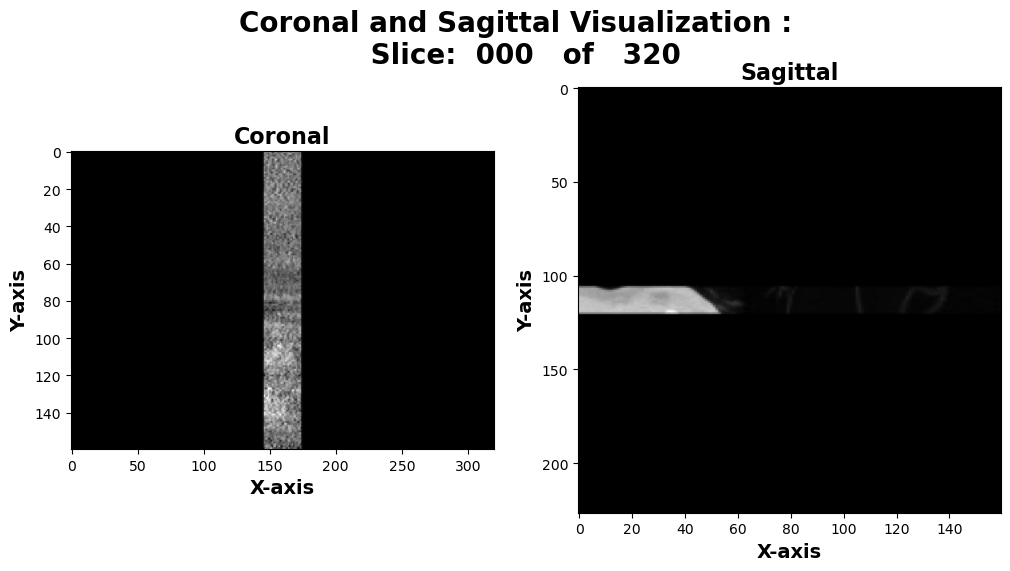

In [14]:
# Set up a loop to generate frames for the animation
fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=False)
def update(frame):
    axs[0].clear()
    axs[0].imshow(imgs_after_resamp[:, frame , :], cmap='gray')
    axs[0].set_title('Coronal', fontsize=16, fontweight='bold')
    axs[0].set_aspect(cor_aspect)
    axs[0].set_xlabel('X-axis', fontsize=14, fontweight='bold')
    axs[0].set_ylabel('Y-axis', fontsize=14, fontweight='bold')

    axs[1].clear()
    axs[1].imshow(imgs_after_resamp[:,:,frame].T, cmap='gray')
    axs[1].set_title('Sagittal', fontsize=16, fontweight='bold')
    axs[1].set_aspect(sag_aspect)
    axs[1].set_xlabel('X-axis', fontsize=14, fontweight='bold')
    axs[1].set_ylabel('Y-axis', fontsize=14, fontweight='bold')
    fig.suptitle('Coronal and Sagittal Visualization : \n Slice:  {:03d}   of   {}'.format(frame, imgs_after_resamp.shape[2]), fontsize=20, fontweight='bold')
    fig.canvas.draw()


# Generate the animation using FuncAnimation
ani = FuncAnimation(fig, update, frames=imgs_after_resamp.shape[2], interval=50)


In [96]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def save_extracted_slices_as_png(imgs_after_resamp, sagittal_start, sagittal_end, coronal_start, coronal_end, output_dir):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Create separate directories for coronal and sagittal images
    coronal_output_dir = os.path.join(output_dir, "coronal_slices")
    sagittal_output_dir = os.path.join(output_dir, "sagittal_slices")
    os.makedirs(coronal_output_dir, exist_ok=True)
    os.makedirs(sagittal_output_dir, exist_ok=True)

    # Extract and save the coronal slices within the specified range
    for coronal_slice in range(coronal_start, coronal_end + 1):
        # Extract the coronal slice
        coronal_img = imgs_after_resamp[:, coronal_slice, :]
        plt.imshow(coronal_img, cmap="gray")  # Use the "gray" colormap
        plt.axis('off')
        # Save PNG image for coronal slice
        coronal_png_filename = os.path.join(coronal_output_dir, f"coronal_{coronal_slice}.png")
        plt.savefig(coronal_png_filename, bbox_inches='tight')  # Save the current plot
        plt.close()  # Close the current plot

    # Extract and save the sagittal slices within the specified range
    for sagittal_slice in range(sagittal_start, sagittal_end + 1):
        # Extract the sagittal slice
        sagittal_img = imgs_after_resamp[:, :, sagittal_slice].T
        plt.imshow(sagittal_img, cmap="gray")  # Use the "gray" colormap
        plt.axis('off')
        # Save PNG image for sagittal slice
        sagittal_png_filename = os.path.join(sagittal_output_dir, f"sagittal_{sagittal_slice}.png")
        plt.savefig(sagittal_png_filename, bbox_inches='tight')  # Save the current plot
        plt.close()  # Close the current plot

# Example usage
sagittal_start = 0  # Replace with your desired sagittal start slice index
sagittal_end = 130   # Replace with your desired sagittal end slice index
coronal_start = 40   # Replace with your desired coronal start slice index
coronal_end = 162     # Replace with your desired coronal end slice index
output_dir = "output_slices"  # Replace with your desired output directory

save_extracted_slices_as_png(imgs_after_resamp, sagittal_start, sagittal_end, coronal_start, coronal_end, output_dir)


# Detect & Save 

In [33]:
# get an array of the slices of the coronal view of the arteries
coronal_imgs = []
for i in range(imgs_after_resamp.shape[1]):
    coronal_imgs.append(imgs_after_resamp[:, i, :])

In [35]:
coronal_imgs = np.array(coronal_imgs)
coronal_imgs.shape

(227, 160, 320)

In [40]:
import os
import numpy as np
from pydicom.dataset import FileDataset
from pydicom.uid import generate_uid
from ultralytics import YOLO
import cv2
from torchvision.transforms import functional as F

# Load the YOLOv5 model
model = YOLO("best.pt")

def detected_array_to_dicom(output_images, output_filename):

    ds = FileDataset(output_filename, {}, file_meta={}, preamble=b"\0" * 128)
    output_images = np.array(output_images)
    # Set necessary DICOM metadata
    ds.Modality = 'CT'
    ds.SeriesInstanceUID = generate_uid()
    ds.StudyInstanceUID = generate_uid()
    ds.FrameOfReferenceUID = generate_uid()
    ds.BitsStored = 8
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "RGB"  # Use MONOCHROME2 for grayscale images
    ds.PixelRepresentation = 0
    ds.HighBit = 15
    ds.Rows = output_images.shape[1]
    ds.Columns = output_images.shape[2]
    ds.NumberOfFrames = output_images.shape[0]  # Set the number of frames to the number of slices

    # Set pixel data
    ds.PixelData = output_images.astype(np.uint8).tobytes()

    # Save DICOM file
    ds.save_as(output_filename)

def detect_and_save_coronal_arrays(imgs_after_resamp, output_dir):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    num_coronal_slices = imgs_after_resamp.shape[1]  # Total number of coronal slices

    output_size = (512, 512)  # Size of the output images
    output_images = []  # List of output images
    # Loop over the images in the numpy array, make predictions, and store them in the `predictions` list
    for img in imgs_after_resamp:

        # convert PIL Image to float 32
        img = img.astype(np.float32)
        # Convert the image to a PIL Image
        img_pil = F.to_pil_image(img)

        # Resize the image to a size divisible by 32
        img_pil = F.resize(img_pil, (640, 640))

        img_pil = np.stack((img_pil,) * 3, axis=-1)

        # Convert the PIL Image to a torch tensor
        img_tensor = F.to_tensor(img_pil)

        # Add a batch dimension to the tensor
        img_tensor = img_tensor.unsqueeze(0)

        # Make predictions using the YOLOv8 model
        results = model(img_tensor)
        # img = img.astype(np.uint8)
        img = np.expand_dims(img, axis=0)
        img = np.repeat(img, 3, axis=0)
        img = np.transpose(img, (1, 2, 0))
        min_value = np.min(img)
        max_value = np.max(img)
        img =  ((img - min_value) * (255 / (max_value - min_value))).astype(np.uint8)

        for result in results:
            try:
                masks = result.masks
                # Apply each mask to the image
                for mask in masks.data:
                    color_mask = np.array([255, 0, 0], dtype=int)  # Red color for the mask
                    mask = mask.bool().numpy()  # Convert mask to boolean array
                    mask = cv2.resize(mask.astype(np.uint8), (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)  # Resize mask to match image dimensions
                    img[mask > 0] = color_mask  # Apply red color to the mask
                    # Resize the image to the common size
                    img = cv2.resize(img, output_size, interpolation=cv2.INTER_LINEAR)
                    # Append the result to the predictions list
                output_images.append(img)
            except:
                print("no masks found")
    id = 0
    detected_array_to_dicom(output_images, os.path.join(output_dir, "coronal_slice_{}.dcm".format(id)))




# Example usage
output_dir = "output_coronal_dicom"  # Output directory for DICOM files

detect_and_save_coronal_arrays(coronal_imgs, output_dir)


0: 640x640 108 carotid-arterys, 680.1ms
Speed: 0.0ms preprocess, 680.1ms inference, 168.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 117 carotid-arterys, 703.1ms
Speed: 0.0ms preprocess, 703.1ms inference, 212.1ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 50.84375. Dividing input by 255.
0: 640x640 (no detections), 387.1ms
Speed: 0.0ms preprocess, 387.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 67.03125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 444.6ms
Speed: 0.0ms preprocess, 444.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 68.65625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 421.1ms
Speed: 0.0ms preprocess, 421.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 58.71875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 406.1ms
Speed: 0.0ms preprocess, 406.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 70.25. Dividing input by 255.


no masks found


0: 640x640 (no detections), 453.6ms
Speed: 0.0ms preprocess, 453.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 79.1875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 396.7ms
Speed: 0.0ms preprocess, 396.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 68.96875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 457.6ms
Speed: 0.0ms preprocess, 457.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 87.15625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 439.7ms
Speed: 0.0ms preprocess, 439.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 81.1875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 394.7ms
Speed: 0.0ms preprocess, 394.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 74.59375. Dividing input by 255.


no masks found


0: 640x640 (no detections), 451.7ms
Speed: 0.0ms preprocess, 451.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 83.21875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 460.2ms
Speed: 0.0ms preprocess, 460.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 98.5. Dividing input by 255.


no masks found


0: 640x640 (no detections), 396.8ms
Speed: 0.0ms preprocess, 396.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 108.0625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 473.6ms
Speed: 0.0ms preprocess, 473.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 412.9375. Dividing input by 255.


no masks found


0: 640x640 (no detections), 447.0ms
Speed: 0.0ms preprocess, 447.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1635.90625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 403.0ms
Speed: 1.0ms preprocess, 403.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2004.625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 456.2ms
Speed: 0.0ms preprocess, 456.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2004.15625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 423.7ms
Speed: 0.0ms preprocess, 423.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2627.9375. Dividing input by 255.


no masks found


0: 640x640 (no detections), 482.6ms
Speed: 0.0ms preprocess, 482.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2712.90625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 418.1ms
Speed: 0.0ms preprocess, 418.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2782.03125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 466.6ms
Speed: 0.0ms preprocess, 466.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2868.125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 486.6ms
Speed: 0.0ms preprocess, 486.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2767.6875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 415.1ms
Speed: 0.0ms preprocess, 415.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2335.5. Dividing input by 255.


no masks found


0: 640x640 (no detections), 467.1ms
Speed: 0.0ms preprocess, 467.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1867.21875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 474.7ms
Speed: 0.0ms preprocess, 474.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1861.1875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 422.2ms
Speed: 0.0ms preprocess, 422.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1852.8125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 470.2ms
Speed: 0.0ms preprocess, 470.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1851.53125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 465.1ms
Speed: 0.0ms preprocess, 465.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1712.0625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 425.6ms
Speed: 0.0ms preprocess, 425.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1702.15625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 485.6ms
Speed: 0.0ms preprocess, 485.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1711.5. Dividing input by 255.


no masks found


0: 640x640 (no detections), 445.1ms
Speed: 0.0ms preprocess, 445.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1715.125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 424.6ms
Speed: 0.0ms preprocess, 424.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1736.59375. Dividing input by 255.


no masks found


0: 640x640 (no detections), 406.1ms
Speed: 0.0ms preprocess, 406.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1737.6875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 444.1ms
Speed: 0.0ms preprocess, 444.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1720.65625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 450.3ms
Speed: 0.0ms preprocess, 450.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1686.5625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 413.1ms
Speed: 0.0ms preprocess, 413.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1701.40625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 451.5ms
Speed: 0.0ms preprocess, 451.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1711.28125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 449.6ms
Speed: 0.0ms preprocess, 449.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1698.21875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 441.1ms
Speed: 0.0ms preprocess, 441.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1682.53125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 412.1ms
Speed: 0.0ms preprocess, 412.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1703.1875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 453.1ms
Speed: 0.0ms preprocess, 453.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1713.71875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 452.2ms
Speed: 0.0ms preprocess, 452.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1692.9375. Dividing input by 255.


no masks found


0: 640x640 (no detections), 404.1ms
Speed: 0.0ms preprocess, 404.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1685.21875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 461.4ms
Speed: 0.0ms preprocess, 461.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1730.25. Dividing input by 255.


no masks found


0: 640x640 (no detections), 407.1ms
Speed: 0.0ms preprocess, 407.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1863.28125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 459.6ms
Speed: 0.0ms preprocess, 459.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1804.21875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 449.6ms
Speed: 0.0ms preprocess, 449.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1764.09375. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 474.1ms
Speed: 0.0ms preprocess, 474.1ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1783.65625. Dividing input by 255.
0: 640x640 1 carotid-artery, 400.1ms
Speed: 0.0ms preprocess, 400.1ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1778.21875. Dividing input by 255.
0: 640x640 1 carotid-artery, 394.3ms
Speed: 0.0ms preprocess, 394.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1817.875. Dividing input by 255.
0: 640x640 1 carotid-artery, 432.1ms
Speed: 0.0ms preprocess, 432.1ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1835.875. Dividing input by 255.
0: 640x640 1 carotid

no masks found


0: 640x640 (no detections), 407.7ms
Speed: 0.0ms preprocess, 407.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1788.4375. Dividing input by 255.


no masks found


0: 640x640 (no detections), 467.1ms
Speed: 0.0ms preprocess, 467.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1790.53125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 451.7ms
Speed: 0.0ms preprocess, 451.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1779.3125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 460.6ms
Speed: 0.0ms preprocess, 460.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1776.46875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 417.0ms
Speed: 0.0ms preprocess, 417.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1683.90625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 461.1ms
Speed: 0.0ms preprocess, 461.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1652.0625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 455.6ms
Speed: 0.0ms preprocess, 455.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1625.15625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 450.1ms
Speed: 0.0ms preprocess, 450.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1703.46875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 412.6ms
Speed: 0.0ms preprocess, 412.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1729.0625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 458.1ms
Speed: 0.0ms preprocess, 458.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1672.8125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 451.5ms
Speed: 0.0ms preprocess, 451.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1647.9375. Dividing input by 255.


no masks found


0: 640x640 (no detections), 425.1ms
Speed: 0.0ms preprocess, 425.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1645.40625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 527.6ms
Speed: 0.0ms preprocess, 527.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1627.96875. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 461.6ms
Speed: 0.0ms preprocess, 461.6ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1572.71875. Dividing input by 255.
0: 640x640 1 carotid-artery, 539.6ms
Speed: 0.0ms preprocess, 539.6ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1602.5. Dividing input by 255.
0: 640x640 (no detections), 459.1ms
Speed: 0.0ms preprocess, 459.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1596.875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 466.6ms
Speed: 0.0ms preprocess, 466.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1602.4375. Dividing input by 255.


no masks found


0: 640x640 (no detections), 545.8ms
Speed: 0.0ms preprocess, 545.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1595.15625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 509.3ms
Speed: 0.0ms preprocess, 509.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1554.5625. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 534.0ms
Speed: 0.0ms preprocess, 534.0ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1454.90625. Dividing input by 255.
0: 640x640 1 carotid-artery, 477.7ms
Speed: 0.0ms preprocess, 477.7ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1523.5625. Dividing input by 255.
0: 640x640 1 carotid-artery, 449.7ms
Speed: 0.0ms preprocess, 449.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1535.375. Dividing input by 255.
0: 640x640 1 carotid-artery, 501.6ms
Speed: 0.0ms preprocess, 501.6ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1532.65625. Dividing input by 255.
0: 640x640 1 caro

no masks found


0: 640x640 (no detections), 528.8ms
Speed: 0.0ms preprocess, 528.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1542.5. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 489.6ms
Speed: 0.0ms preprocess, 489.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1643.46875. Dividing input by 255.
0: 640x640 1 carotid-artery, 518.5ms
Speed: 0.0ms preprocess, 518.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3071.0. Dividing input by 255.
0: 640x640 (no detections), 489.1ms
Speed: 0.0ms preprocess, 489.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3063.8125. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 499.6ms
Speed: 0.0ms preprocess, 499.6ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3071.0. Dividing input by 255.
0: 640x640 1 carotid-artery, 471.6ms
Speed: 1.0ms preprocess, 471.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3071.0. Dividing input by 255.
0: 640x640 1 carotid-artery, 658.6ms
Speed: 0.0ms preprocess, 658.6ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3071.0. Dividing input by 255.
0: 640x640 (no detections), 491.6ms
Speed: 0.0ms preprocess, 491.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3071.0. Dividing input by 255.


no masks found


0: 640x640 (no detections), 519.6ms
Speed: 0.0ms preprocess, 519.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3071.0. Dividing input by 255.


no masks found


0: 640x640 (no detections), 536.2ms
Speed: 0.0ms preprocess, 536.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3070.96875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 505.6ms
Speed: 1.0ms preprocess, 505.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3071.0. Dividing input by 255.


no masks found


0: 640x640 (no detections), 524.2ms
Speed: 0.0ms preprocess, 524.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2588.75. Dividing input by 255.


no masks found


0: 640x640 (no detections), 544.7ms
Speed: 0.0ms preprocess, 544.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1902.78125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 474.6ms
Speed: 0.0ms preprocess, 474.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1930.375. Dividing input by 255.


no masks found


0: 640x640 (no detections), 535.8ms
Speed: 0.0ms preprocess, 535.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1883.65625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 547.6ms
Speed: 0.0ms preprocess, 547.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1885.625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 506.6ms
Speed: 0.0ms preprocess, 506.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1905.28125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 469.1ms
Speed: 0.0ms preprocess, 469.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1947.75. Dividing input by 255.


no masks found


0: 640x640 (no detections), 537.6ms
Speed: 0.0ms preprocess, 537.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1914.375. Dividing input by 255.


no masks found


0: 640x640 (no detections), 490.6ms
Speed: 0.0ms preprocess, 490.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1860.75. Dividing input by 255.


no masks found


0: 640x640 (no detections), 530.8ms
Speed: 0.0ms preprocess, 530.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1855.03125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 483.6ms
Speed: 0.0ms preprocess, 483.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1860.4375. Dividing input by 255.


no masks found


0: 640x640 (no detections), 532.3ms
Speed: 0.0ms preprocess, 532.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1783.3125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 468.6ms
Speed: 0.0ms preprocess, 468.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1733.8125. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 534.2ms
Speed: 0.0ms preprocess, 534.2ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1725.75. Dividing input by 255.
0: 640x640 1 carotid-artery, 451.1ms
Speed: 0.0ms preprocess, 451.1ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1707.375. Dividing input by 255.
0: 640x640 1 carotid-artery, 456.1ms
Speed: 0.0ms preprocess, 456.1ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2741.5625. Dividing input by 255.
0: 640x640 1 carotid-artery, 501.6ms
Speed: 0.0ms preprocess, 501.6ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3071.0. Dividing input by 255.
0: 640x640 1 carotid-arte

no masks found


0: 640x640 (no detections), 524.7ms
Speed: 0.0ms preprocess, 524.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1648.1875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 515.9ms
Speed: 0.0ms preprocess, 515.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1601.0. Dividing input by 255.


no masks found


0: 640x640 (no detections), 488.1ms
Speed: 0.0ms preprocess, 488.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1668.75. Dividing input by 255.


no masks found


0: 640x640 (no detections), 530.6ms
Speed: 0.0ms preprocess, 530.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1929.0625. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 527.2ms
Speed: 0.0ms preprocess, 527.2ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1586.53125. Dividing input by 255.
0: 640x640 (no detections), 452.0ms
Speed: 0.0ms preprocess, 452.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1595.84375. Dividing input by 255.


no masks found


0: 640x640 (no detections), 514.6ms
Speed: 0.0ms preprocess, 514.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1686.625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 522.6ms
Speed: 0.0ms preprocess, 522.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1603.46875. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 526.1ms
Speed: 0.0ms preprocess, 526.1ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1837.25. Dividing input by 255.
0: 640x640 (no detections), 435.1ms
Speed: 0.0ms preprocess, 435.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2047.375. Dividing input by 255.


no masks found


0: 640x640 (no detections), 470.4ms
Speed: 0.0ms preprocess, 470.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2549.3125. Dividing input by 255.


no masks found


0: 640x640 2 carotid-arterys, 536.2ms
Speed: 0.0ms preprocess, 536.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3043.875. Dividing input by 255.
0: 640x640 1 carotid-artery, 468.6ms
Speed: 0.0ms preprocess, 468.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3071.0. Dividing input by 255.
0: 640x640 (no detections), 505.6ms
Speed: 0.0ms preprocess, 505.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3071.0. Dividing input by 255.


no masks found


0: 640x640 (no detections), 512.6ms
Speed: 0.0ms preprocess, 512.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3071.0. Dividing input by 255.


no masks found


0: 640x640 (no detections), 482.1ms
Speed: 0.0ms preprocess, 482.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3071.0. Dividing input by 255.


no masks found


0: 640x640 (no detections), 557.6ms
Speed: 0.0ms preprocess, 557.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3071.0. Dividing input by 255.


no masks found


0: 640x640 (no detections), 550.1ms
Speed: 0.0ms preprocess, 550.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3071.0. Dividing input by 255.


no masks found


0: 640x640 (no detections), 498.6ms
Speed: 0.0ms preprocess, 498.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3049.875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 563.6ms
Speed: 0.0ms preprocess, 563.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1814.0625. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 560.1ms
Speed: 0.0ms preprocess, 560.1ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1577.84375. Dividing input by 255.
0: 640x640 (no detections), 497.2ms
Speed: 0.0ms preprocess, 497.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1557.0. Dividing input by 255.


no masks found


0: 640x640 (no detections), 560.2ms
Speed: 0.0ms preprocess, 560.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1533.625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 517.6ms
Speed: 0.0ms preprocess, 517.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1550.75. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 583.6ms
Speed: 0.0ms preprocess, 583.6ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1550.46875. Dividing input by 255.
0: 640x640 (no detections), 503.6ms
Speed: 0.0ms preprocess, 503.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1543.53125. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 598.1ms
Speed: 0.0ms preprocess, 598.1ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1556.84375. Dividing input by 255.
0: 640x640 (no detections), 505.6ms
Speed: 0.0ms preprocess, 505.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1563.84375. Dividing input by 255.


no masks found


0: 640x640 2 carotid-arterys, 595.1ms
Speed: 0.0ms preprocess, 595.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1570.5. Dividing input by 255.
0: 640x640 1 carotid-artery, 472.6ms
Speed: 0.0ms preprocess, 472.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1564.34375. Dividing input by 255.
0: 640x640 1 carotid-artery, 505.6ms
Speed: 0.0ms preprocess, 505.6ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1547.65625. Dividing input by 255.
0: 640x640 1 carotid-artery, 481.6ms
Speed: 0.0ms preprocess, 481.6ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1544.5. Dividing input by 255.
0: 640x640 (no detect

no masks found


0: 640x640 (no detections), 513.6ms
Speed: 0.0ms preprocess, 513.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1537.71875. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 554.8ms
Speed: 0.0ms preprocess, 554.8ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1562.1875. Dividing input by 255.
0: 640x640 (no detections), 471.7ms
Speed: 0.0ms preprocess, 471.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1574.0625. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 468.6ms
Speed: 0.0ms preprocess, 468.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1571.0. Dividing input by 255.
0: 640x640 (no detections), 504.6ms
Speed: 0.0ms preprocess, 504.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1564.84375. Dividing input by 255.


no masks found


0: 640x640 (no detections), 472.6ms
Speed: 0.0ms preprocess, 472.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2562.5. Dividing input by 255.


no masks found


0: 640x640 (no detections), 516.6ms
Speed: 0.0ms preprocess, 516.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 3071.0. Dividing input by 255.


no masks found


0: 640x640 (no detections), 487.6ms
Speed: 0.0ms preprocess, 487.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2961.0625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 547.2ms
Speed: 0.0ms preprocess, 547.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1532.84375. Dividing input by 255.


no masks found


0: 640x640 (no detections), 486.6ms
Speed: 0.0ms preprocess, 486.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1533.1875. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 547.3ms
Speed: 0.0ms preprocess, 547.3ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1544.84375. Dividing input by 255.
0: 640x640 1 carotid-artery, 471.6ms
Speed: 0.0ms preprocess, 471.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1556.65625. Dividing input by 255.
0: 640x640 (no detections), 464.2ms
Speed: 0.0ms preprocess, 464.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1564.09375. Dividing input by 255.


no masks found


0: 640x640 (no detections), 526.2ms
Speed: 0.0ms preprocess, 526.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1574.90625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 507.6ms
Speed: 0.0ms preprocess, 507.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1572.90625. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 577.2ms
Speed: 1.0ms preprocess, 577.2ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1580.25. Dividing input by 255.
0: 640x640 1 carotid-artery, 477.1ms
Speed: 0.0ms preprocess, 477.1ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1583.3125. Dividing input by 255.
0: 640x640 (no detections), 476.9ms
Speed: 0.0ms preprocess, 476.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1579.75. Dividing input by 255.


no masks found


0: 640x640 (no detections), 539.1ms
Speed: 0.0ms preprocess, 539.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1593.75. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 481.5ms
Speed: 0.0ms preprocess, 481.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1603.21875. Dividing input by 255.
0: 640x640 2 carotid-arterys, 478.6ms
Speed: 0.0ms preprocess, 478.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1593.5625. Dividing input by 255.
0: 640x640 2 carotid-arterys, 461.6ms
Speed: 0.0ms preprocess, 461.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1592.25. Dividing input by 255.
0: 640x640 2 carotid-arterys, 499.7ms
Speed: 0.0ms preprocess, 499.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1603.46875. Dividing input by 255.
0: 640x640 1 caro

no masks found


0: 640x640 1 carotid-artery, 517.1ms
Speed: 0.0ms preprocess, 517.1ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1577.0. Dividing input by 255.
0: 640x640 1 carotid-artery, 454.2ms
Speed: 0.0ms preprocess, 454.2ms inference, 10.5ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1581.21875. Dividing input by 255.
0: 640x640 1 carotid-artery, 519.3ms
Speed: 0.0ms preprocess, 519.3ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1563.0. Dividing input by 255.
0: 640x640 (no detections), 450.5ms
Speed: 0.0ms preprocess, 450.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1548.375. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 542.6ms
Speed: 0.0ms preprocess, 542.6ms inference, 8.3ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1549.78125. Dividing input by 255.
0: 640x640 1 carotid-artery, 465.9ms
Speed: 0.0ms preprocess, 465.9ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1540.15625. Dividing input by 255.
0: 640x640 2 carotid-arterys, 580.1ms
Speed: 0.0ms preprocess, 580.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1535.15625. Dividing input by 255.
0: 640x640 (no detections), 458.8ms
Speed: 0.0ms preprocess, 458.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1510.03125. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 465.0ms
Speed: 0.0ms preprocess, 465.0ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1532.4375. Dividing input by 255.
0: 640x640 1 carotid-artery, 475.9ms
Speed: 0.0ms preprocess, 475.9ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1473.0. Dividing input by 255.
0: 640x640 3 carotid-arterys, 511.7ms
Speed: 0.0ms preprocess, 511.7ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1254.25. Dividing input by 255.
0: 640x640 2 carotid-arterys, 460.6ms
Speed: 0.0ms preprocess, 460.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1022.625. Dividing input by 255.
0: 640x640 2 carotid-ar

no masks found


0: 640x640 (no detections), 535.8ms
Speed: 0.0ms preprocess, 535.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 969.65625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 550.1ms
Speed: 0.0ms preprocess, 550.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1027.6875. Dividing input by 255.


no masks found


0: 640x640 1 carotid-artery, 504.4ms
Speed: 0.0ms preprocess, 504.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1049.71875. Dividing input by 255.
0: 640x640 1 carotid-artery, 545.2ms
Speed: 0.0ms preprocess, 545.2ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1033.84375. Dividing input by 255.
0: 640x640 (no detections), 467.8ms
Speed: 0.0ms preprocess, 467.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1032.75. Dividing input by 255.


no masks found


0: 640x640 (no detections), 533.6ms
Speed: 0.0ms preprocess, 533.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 932.125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 497.6ms
Speed: 0.0ms preprocess, 497.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 798.15625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 569.1ms
Speed: 0.0ms preprocess, 569.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 855.625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 497.2ms
Speed: 0.0ms preprocess, 497.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 826.15625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 553.1ms
Speed: 0.0ms preprocess, 553.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 936.1875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 496.6ms
Speed: 0.0ms preprocess, 496.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 939.25. Dividing input by 255.


no masks found


0: 640x640 (no detections), 540.2ms
Speed: 0.0ms preprocess, 540.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 1001.0. Dividing input by 255.


no masks found


0: 640x640 (no detections), 497.2ms
Speed: 0.0ms preprocess, 497.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 967.875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 541.1ms
Speed: 0.0ms preprocess, 541.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 849.46875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 566.6ms
Speed: 0.0ms preprocess, 566.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 713.03125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 486.7ms
Speed: 0.0ms preprocess, 486.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 666.25. Dividing input by 255.


no masks found


0: 640x640 (no detections), 566.6ms
Speed: 0.0ms preprocess, 566.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 634.0. Dividing input by 255.


no masks found


0: 640x640 (no detections), 544.6ms
Speed: 0.0ms preprocess, 544.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 616.03125. Dividing input by 255.


no masks found


0: 640x640 (no detections), 526.6ms
Speed: 0.0ms preprocess, 526.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 533.71875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 548.6ms
Speed: 0.0ms preprocess, 548.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 552.5625. Dividing input by 255.


no masks found


0: 640x640 (no detections), 494.5ms
Speed: 0.0ms preprocess, 494.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

WARNING  torch.Tensor inputs should be normalized 0.0-1.0 but max value is 523.96875. Dividing input by 255.


no masks found


0: 640x640 (no detections), 547.9ms
Speed: 0.0ms preprocess, 547.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


no masks found


In [98]:
import os
import numpy as np
from PIL import Image
from pydicom import dcmread
from pydicom.dataset import FileDataset
from pydicom.uid import generate_uid

def pngs_to_dicom(input_dir, output_dir, series_ID):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # List PNG files in the input directory
    png_files = [f for f in os.listdir(input_dir) if f.endswith('.png')]
    png_files.sort()  # Sort the PNG files to maintain the correct order of slices
    
    if not png_files:
        raise ValueError("No PNG files found in the input directory")
    
    # Read the first PNG to get image size and initialize the 3D volume array
    first_png_path = os.path.join(input_dir, png_files[0])
    first_png_image = Image.open(first_png_path)
    np_frame_shape = (len(png_files), first_png_image.size[1], first_png_image.size[0], 3)
    np_volume = np.zeros(np_frame_shape, dtype=np.uint8)
    
    # Load each PNG image and stack them to create the 3D volume
    for idx, png_filename in enumerate(png_files):
        png_path = os.path.join(input_dir, png_filename)
        png_image = Image.open(png_path)
        np_frame = np.array(png_image)[:,:,:3]
        np_volume[idx] = np_frame
    
    # Create DICOM dataset for the 3D volume
    dicom_filename = os.path.join(output_dir, f"{series_ID}.dcm")
    ds = FileDataset(dicom_filename, {}, file_meta={}, preamble=b"\0" * 128)
    
    # Set necessary DICOM metadata (assuming all slices have the same metadata)
    ds.Modality = 'CT'
    ds.SeriesInstanceUID = generate_uid()
    ds.StudyInstanceUID = generate_uid()
    ds.FrameOfReferenceUID = generate_uid()
    ds.BitsStored = 8
    ds.SamplesPerPixel = 3  # RGB image has 3 samples per pixel
    ds.PhotometricInterpretation = "RGB"
    ds.PixelRepresentation = 0
    ds.HighBit = 7
    ds.Rows = np_frame_shape[1]
    ds.Columns = np_frame_shape[2]
    ds.NumberOfFrames = np_frame_shape[0]  # Number of frames is the number of PNG slices

    # Set pixel data
    ds.PixelData = np_volume.tobytes()

    # Save DICOM file
    ds.save_as(dicom_filename)

# Example usage
input_dir = "output_slices/coronal_slices"  # Directory containing PNG images
output_dir = "output_/coronal_dicom"  # Replace with your desired output directory for DICOM files
series_ID = "12345"  # Replace with your desired series ID

pngs_to_dicom(input_dir, output_dir, series_ID)

